### Imprts

In [1]:
import matplotlib.pyplot as plt
import numpy as np

### Define the nodes and their values for the first year

In [30]:
nodes = {
    "A. Production": 107000.0,
    "B. Import": 131000.0,
    "B`. Illegal import": [],
    "C. Sales (new)": 0.0,
    "D. Sales (second-hand)": 0.0,
    "E. Use phase": 920000.0,
    # "F. Tyres remaning in use phase": 0.0,
    "G. Collection points": 0.0,
    "H. Reuse and retreading": 0.0,
    "I. Formal collection": 93400, 
    "J. Informal collection": 0.0, 
    "K. Mirco-collection": 29000, 
    "L. Wear and tear": 0.0, 
    "M. Landfilling/illegal dumping": [0.0, 0.0, 0.0], 
    # "N. Historical stockpiles": 22000000,
    "O. Export of Waste": 14400, 
    "P. Long-term stockpilling": 213000, # max cap is 250000, when full it all goes to "J. Informal collection"
    "Q. Depots/pre-processing": 22700, 
    "R. Formal processing": 0.0, 
    "S. Informal processing": 0.0, 
    "T. Crumbing": 0.0, 
    "U. Pyrolysis": 0.0, 
    "V. Energy recovery": 0.0, 
    "W. Secondary Industry": 0.0
    }

### Define the flow multiples for the nodes

In [31]:
flows_multiples = {
    "1 (A to C)": 1,
    "2 (B to C)": 1,
    "3 (B` to D)": 1,
    "4 (C to E)": 1,
    "5 (D to E)": 1,
    "6 (E to L)": 0.035,                # estimated by taking a 10 year CAGR for tyres
    # "7": 1 - 0.054347826 - 0.326086957, 
    # "8": 1,
    "9 (E to G)": 0.326086957,          # estimated by taking current year data into a ratio: 300,000 / 920,000
    "10": 0,                            # not enough data to make an estimate 
    # "11": 0,                          
    "12 (H to D)": 1,
    "13 (G to I)": 0.214666667,         # estimated by taking current year data into a ratio: (93,400 - 29,000) / 300,000
    "14 (G to J)": 1 - 0.214666667,     # the remained of tons in `G. Collection points`
    "15 ": 1,
    "16": 93,                           # estimated by taking the remained of J. Informal collection - flow26 - flow15
    "17": 0.001318182,                  # estimated by taking current year data into a ratio: 14,500 / ???
    "18": 0.001318182,                  # estimated by taking current year data into a ratio: 14,500 / 22,000,000
    "19 (K to I)": 1,
    "20": .24,                          # estimated by taking current year data into a ratio: 27,600 / 93,400
    "21": .15,                          # estimated by taking current year data into a ratio: 14,400 / 93,400
    "22 (I to P)": 0.602783726,         # estimated by taking current year data into a ratio: (93,400 - 27,600 - 14,400) / 93,400
    "23": 0,
    "24": 1,
    "25": 0,
    "26": 0,
    "27": .43,
    "28": .21,
    "29": .36,
    "30": 1,
}

### Define the flow and run the model
This is where the where all of the values are calculated and appended to the `data` arrays for each `year`.

In [40]:
previous_year_use_phase = nodes["E. Use phase"]
demand_increase = 1.045
years = 15
data_m, data_p, data_h = [], [], []

# run the model `years` number of times
for year in range(years):
    
    # Calculate `C. Sales (new)` by adding up `A. Production` and `B. Import.
    nodes["C. Sales (new)"] = nodes["A. Production"] + nodes["B. Import"]
    
    # Increase `A. Production` and `B. Import` by 4.5% per year after the first year
    nodes["A. Production"] *= demand_increase
    nodes["B. Import"] *= demand_increase

    # In order to calulate the value of `D. Sales (second-hand)` we need to know the demand_gap_for_use_phase
    # Which is calculated by checking the net change in `E. Use phase`, for wich we need to know the value of `G. Collection points` and `L. Wear and tear`
    # calculate the value of `G. Collection points`
    nodes["G. Collection points"] = nodes["E. Use phase"] * flows_multiples["9 (E to G)"]
    # calculate the value of `L. Wear and tear`
    nodes["L. Wear and tear"] = nodes["E. Use phase"] * flows_multiples["6 (E to L)"]

    # the demand gap is calculated by taking "demand change from year to year (in year one it's 0)", adding G and L and subtracting C
    demand_gap_for_use_phase = nodes["E. Use phase"] - previous_year_use_phase + nodes["G. Collection points"] + nodes["L. Wear and tear"] - nodes["C. Sales (new)"]
    
    # previous year and next year use phase is updated
    previous_year_use_phase = nodes["E. Use phase"]
    nodes["E. Use phase"] *= demand_increase

    # `D. Sales (second-hand)` must be equal to `demand_gap_for_use_phase` to bring 4.5% growth in demand
    # `D. Sales (second-hand)` is composed of `B`. Illegal import` and `H. Reuse and retreading`
    # Seince we don't know their value we can asign them to a range where B` + H = D, and B` = [0, D] and H = [0, D]
    nodes["B`. Illegal import"] = [0, demand_gap_for_use_phase/2, demand_gap_for_use_phase]
    nodes["H. Reuse and retreading"] = [demand_gap_for_use_phase - i for i in nodes["B`. Illegal import"]]

    # Calcualte `I. Formal Collection`
    nodes["I. Formal collection"] = nodes["G. Collection points"] * flows_multiples["13 (G to I)"]

    # Calcualte `J. Informal collection`
    nodes["J. Informal collection"] = nodes["G. Collection points"] * flows_multiples["14 (G to J)"]
    
    # Calcualte `M. Landfilling/illegal dumping`
    goes_to_m_from_j = [nodes["J. Informal collection"] - h for h in nodes["H. Reuse and retreading"]]    
    nodes["M. Landfilling/illegal dumping"] += goes_to_m_from_j

    # Calculate `P. Long-term stockpiling`, if it overflows add it to `M. Landfilling/illegal dumping`
    goes_to_p = nodes["I. Formal collection"] * flows_multiples["22 (I to P)"]
    if nodes["P. Long-term stockpilling"] + goes_to_p > 250000:
        # the amount over 250000 goes to `M. Landfilling/illegal dumping`
        add_to_m = nodes["P. Long-term stockpilling"] + goes_to_p - 250000
        nodes["M. Landfilling/illegal dumping"] = [i + add_to_m for i in nodes["M. Landfilling/illegal dumping"]]

    data_m.append(nodes["M. Landfilling/illegal dumping"][1])
    data_p.append(nodes["P. Long-term stockpilling"])
    data_h.append(nodes["H. Reuse and retreading"][0])

### Plotting

[1732258.48326114 1868639.38707951 2012822.4315697  2165158.71306195
 2326015.12722135 2495775.08001792 2674839.23069034 2863626.26814302
 3062573.72228107 3272138.81185533 3492799.33046043 3725054.57240276
 3969426.3002325  4226459.75581458 4496724.71689784]


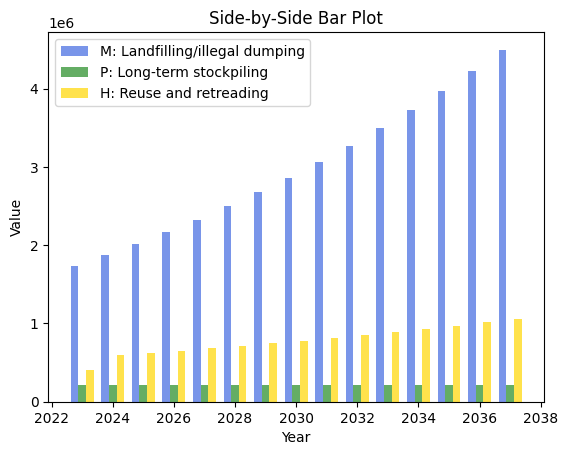

In [47]:
# Sample time-series data (replace this with your actual data)
years = np.arange(2023, 2038)  # Example years from 2000 to 2020
values1 = np.array(data_m)  # Example values for dataset 1
values2 = np.array(data_p)  # Example values for dataset 2
values3 = np.array(data_h)  # Example values for dataset 3
print(values1)

# Set up the figure and axes
fig, ax = plt.subplots()

# Calculate the width of each bar
bar_width = 0.25

# Create bar plots with side-by-side bars and specified colors
ax.bar(years - bar_width, values1, label='M: Landfilling/illegal dumping', width=bar_width, alpha=0.7, color='royalblue')
ax.bar(years, values2, label='P: Long-term stockpiling', width=bar_width, alpha=0.7, color='forestgreen')
ax.bar(years + bar_width, values3, label='H: Reuse and retreading', width=bar_width, alpha=0.7, color='gold')

# Customize the appearance
ax.set_xlabel('Year')
ax.set_ylabel('Value')
ax.set_title('Side-by-Side Bar Plot')
ax.legend()

# Display the plot
plt.show()


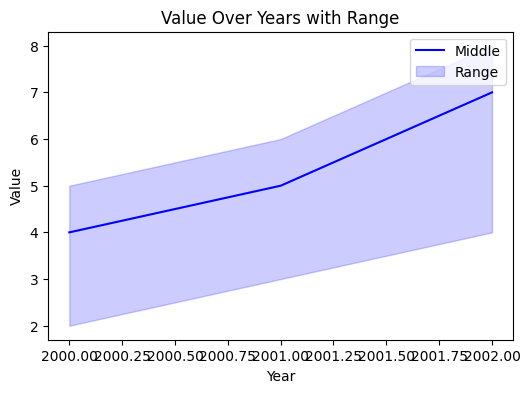

In [46]:
# Sample data
data = np.array([[2, 4, 5], [3, 5, 6], [4, 7, 8]])  # Replace this with your actual data
years = np.arange(2000, 2003, 1)

# Plotting
plt.figure(figsize=(6, 4))

# Plot the middle line
plt.plot(years, data[:, 1], label='Middle', color='blue')

# Fill the range between the lower and upper bounds
plt.fill_between(years, data[:, 0], data[:, 2], color='blue', alpha=0.2, label='Range')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Value Over Years with Range')
plt.legend()

# Show the plot
plt.show()
